# Utilizando MNE para representar e trabalhar com os dados

Nesta aula será apresentado como trabalhar com os a biblioteca MNE para representar os dados de EEG, facilitando o armazenamento de todas as informações em um único objeto.

Além disso, somente a biblioteca MNE permite executar diversas operações de pré-processamento do *dataset*, além de outras operações utilizadas durante o processamento SSVEP (Nosso objeto de estudo inicial).

Como na aula anterior não temos um objeto pronto para trabalho, partimos do produto final gerado, no qual está armazenado nos objetos `X`, `y` e `descriptor`:

In [1]:
%run prepare.ipynb

Estruturas => dados (125, 257, 1205) labels (125,)
Características do voluntário: {'age': '25', 'capsize': 'Adult Medium', 'gender': 'Male', 'hairtype': 'Regular', 'handedness': 'Right'}

Rótulos: {'1': 6.66, '2': 7.5, '3': 8.57, '4': 10.0, '5': 12.0}

Taxa de amostragem: 250
Nova taxa de amostragem: 241.0 Hz


### MNE *info descriptor*

O primeiro passo -- correto -- é criar um objeto `info`, que servirá como descrição do objeto MNE. Os valores mais importantes de descrição do objeto são: nome dos eletrodos, taxa de amostragem e tipo do sinal.

In [2]:
import matplotlib

%matplotlib inline
# aumentando a escala das figuras no matplotlib (padrão 6. x 4.)
matplotlib.rcParams['figure.figsize'] = [12, 8]
import mne

# objeto com o nome dos canais pelo modelo da touca utilizada
montage = mne.channels.make_standard_montage('EGI_256')
# criando o objeto `info` (o restante dos valores já temos)
info = mne.create_info(montage.ch_names,
                       sfreq=descriptor['sampling_rate'],
                       ch_types='eeg')
info.set_montage(montage)
info

<Info | 8 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 256 EEG
 custom_ref_applied: False
 dig: 259 items (3 Cardinal, 256 EEG)
 highpass: 0.0 Hz
 lowpass: 120.5 Hz
 meas_date: unspecified
 nchan: 256
 projs: []
 sfreq: 241.0 Hz
>

Podemos verificar que o nome dos canais não nos ajudou muito. Isto ocorre porque o modelo utilizado não é o "padrão 10-20" ou "padrão 10-05". Desta forma, nome de canais como `O1`, `O2`, `Pz` não estarão explícitos para consulta e outras operações :-(.

Vamos então utilizar informações do artigo, no qual são mostradas alguns mapeamentos destes nomes genéricos (`E1`, `E2`, etc) para os nomes no padrão internacional 10-20:

| 256 HCGSN | 10-20 System | 256 HCGSN | 10-20 System |
|:---------:|:------------:|:---------:|:------------:|
|     47    |      F7      |     21    |      Fz      |
|     37    |      Fp1     |    183    |      C4      |
|     36    |      F3      |    170    |      P8      |
|     2     |      F8      |    150    |      O2      |
|    101    |      Pz      |    224    |      F4      |
|    126    |      Oz      |    190    |      RM      |
|     69    |      T7      |     31    |      NAS     |
|     96    |      P7      |     18    |      FP2     |
|     94    |      LM      |    116    |      O1      |
|    202    |      T8      |           |              |

Além desse mapeamento aproximado, podemos comparar outros, por meio de mapeamentos dos padrões armazenados na própria biblioteca:

EGI 256
Creating RawArray with float64 data, n_channels=256, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


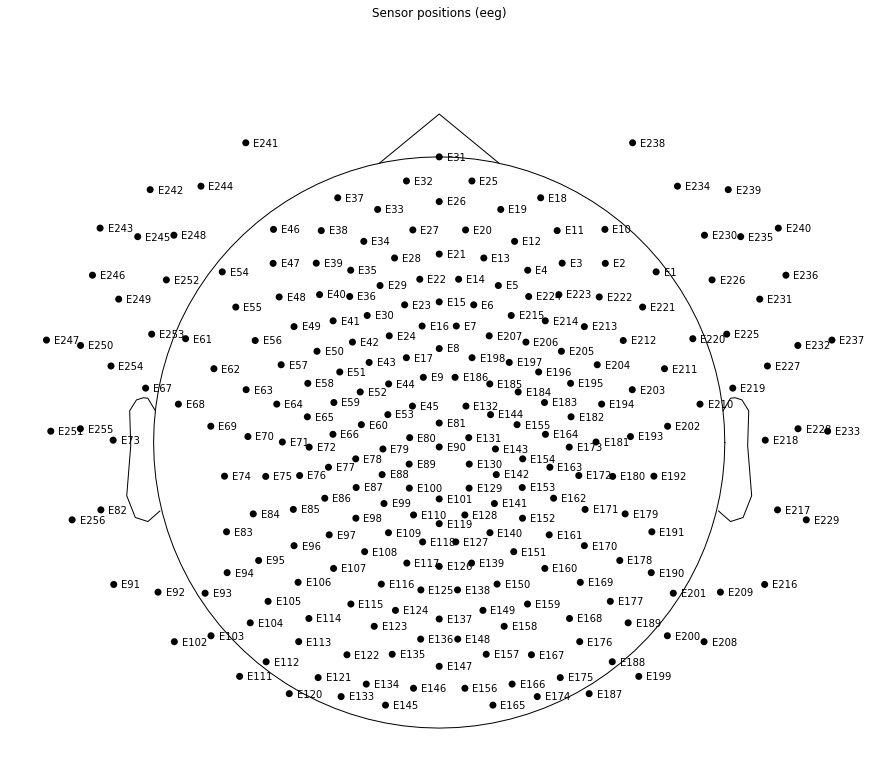

10-20 SYSTEM
4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


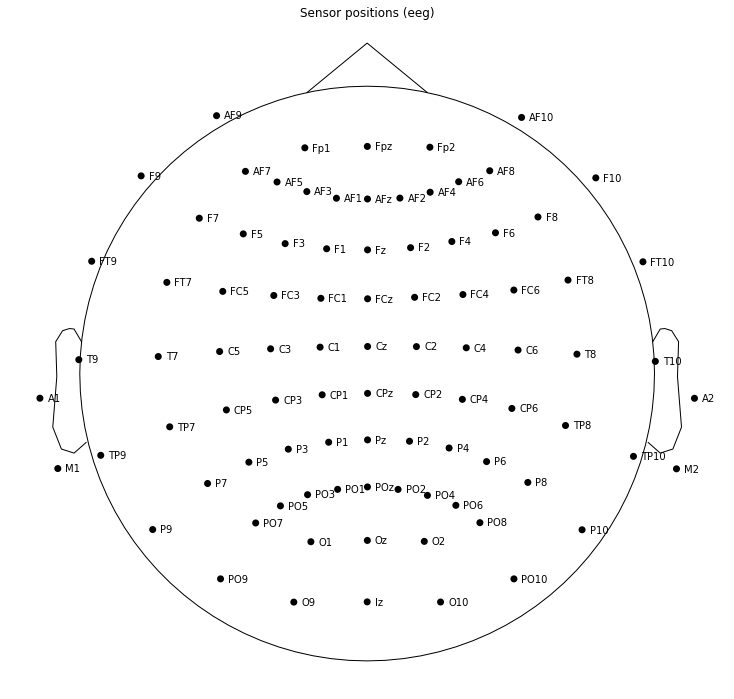

In [3]:
# plotando o padrão EGI 256
print('EGI 256')
montage.plot()
# plotando o padrão 10-20
print('10-20 SYSTEM')
# neste padrão a figura estava ficando maior, então diminuí
matplotlib.rcParams['figure.figsize'] = [10, 7]
mne.channels.make_standard_montage('standard_1020').plot()
print()

### Criando um objeto MNE Epoch

Discutido o objeto info, vamos criar objeto principal com os dados do experimento.

A princípio, precisamos preparar o parâmetro `events` do objeto `EpochArray`, que armazena os marcadores do experimento (aqueles marcadores que estão armazenados no nosso objeto `descriptor`).

Por fim, adicionamos o parâmetro `info` que acabamos de criar.

In [4]:
# o 257º eletrodo é o VREF (referência). Inútil -> Podemos tirá-lo...
X = X[:,:256,:]
# objeto event é uma matriz tridimensional conforme explicado em aula
events = np.array([[i, 0, e] for i, e in enumerate(y)])
# instanciando objeto EpochArray
epoch = mne.EpochsArray(X, info, events=events)
epoch

125 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<EpochsArray  |   125 events (all good), 0 - 4.99585 sec, baseline off, ~294.8 MB, data loaded,
 '1': 25
 '2': 25
 '3': 30
 '4': 25
 '5': 20>

### Iniciando trabalhos com MNE Epoch

Com o objeto MNE criado, podemos realizar algumas operações iniciais de demonstração.

A primeira coisa que faremos é filtrar alguns eletrodos de maior interesse (p/ experimentos SSVEP) e visualizar alguns plots básicos...

In [5]:
# Filtrando apenas dados dos eletrodos (O1, Oz e O2), (P7-Pz-P8) e (PO7-POz-PO8)
epoch_ex = epoch.copy().pick_channels(['E116', 'E126', 'E150', 'E96', 'E97', 'E98', 'E99', 'E101', 'E141', 
                                       'E152', 'E161', 'E170', 'E107', 'E108', 'E109', 'E119', 'E140', 'E151', 'E160'])
epoch_ex

<EpochsArray  |   125 events (all good), 0 - 4.99585 sec, baseline off, ~22.0 MB, data loaded,
 '1': 25
 '2': 25
 '3': 30
 '4': 25
 '5': 20>

Para demonstrar que estamos apenas com os 3 eletrodos agora, mostramos o shape de ambos os objetos criados

In [6]:
print(epoch.get_data().shape)
print(epoch_ex.get_data().shape)

(125, 256, 1205)
(125, 19, 1205)


Setting up band-pass filter from 5 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 399 samples (1.656 sec)

Evento:  1
Trial:  1
    Using multitaper spectrum estimation with 7 DPSS windows


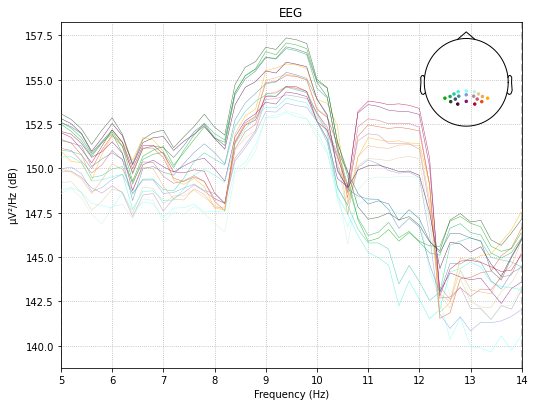

Trial:  3
    Using multitaper spectrum estimation with 7 DPSS windows


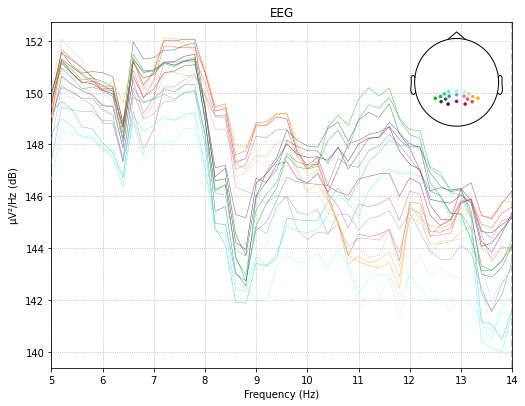

Trial:  9
    Using multitaper spectrum estimation with 7 DPSS windows


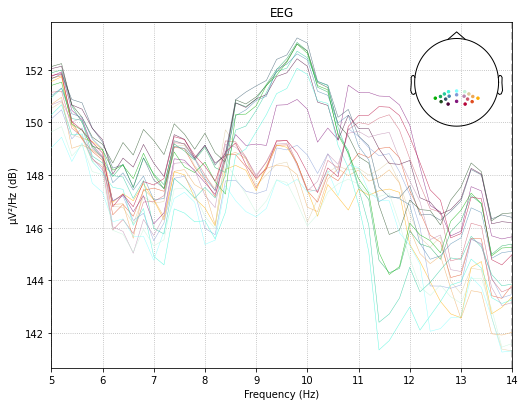

Trial:  11
    Using multitaper spectrum estimation with 7 DPSS windows


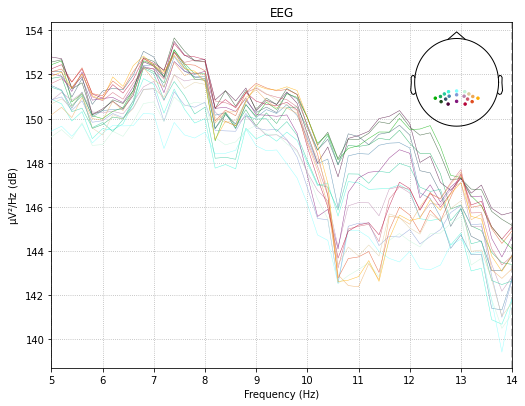

    Using multitaper spectrum estimation with 7 DPSS windows


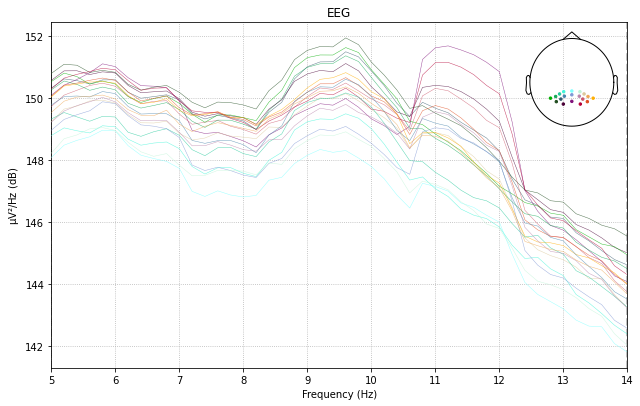

Evento:  2
Trial:  1
    Using multitaper spectrum estimation with 7 DPSS windows


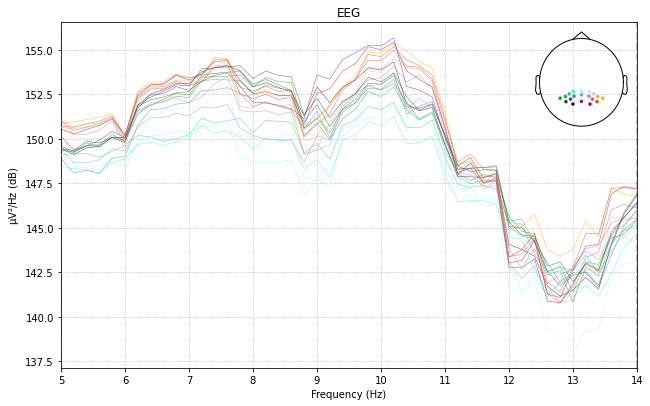

Trial:  3
    Using multitaper spectrum estimation with 7 DPSS windows


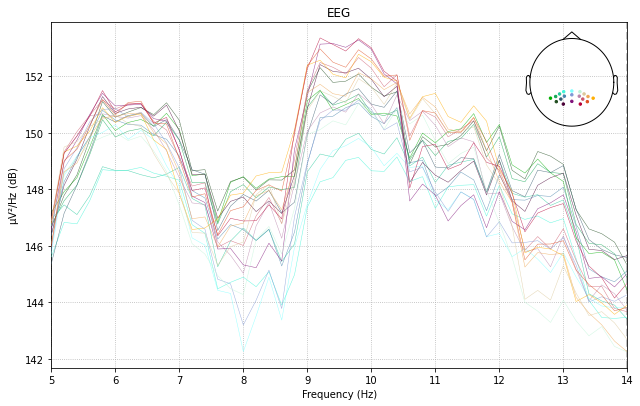

Trial:  9
    Using multitaper spectrum estimation with 7 DPSS windows


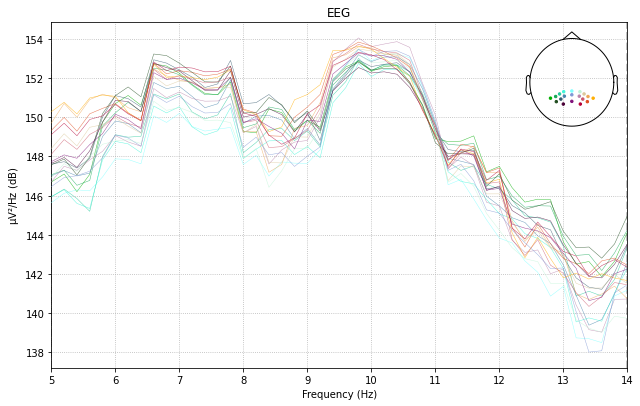

Trial:  11
    Using multitaper spectrum estimation with 7 DPSS windows


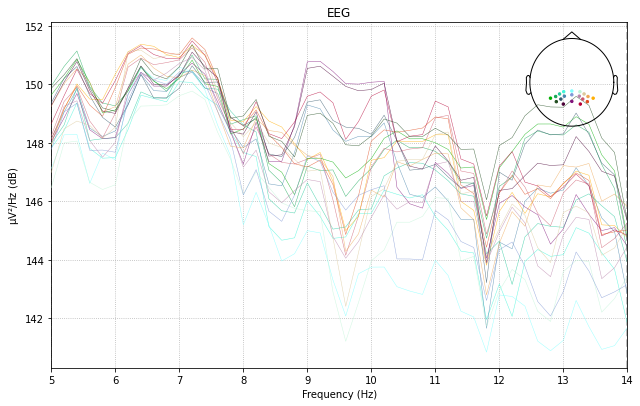

    Using multitaper spectrum estimation with 7 DPSS windows


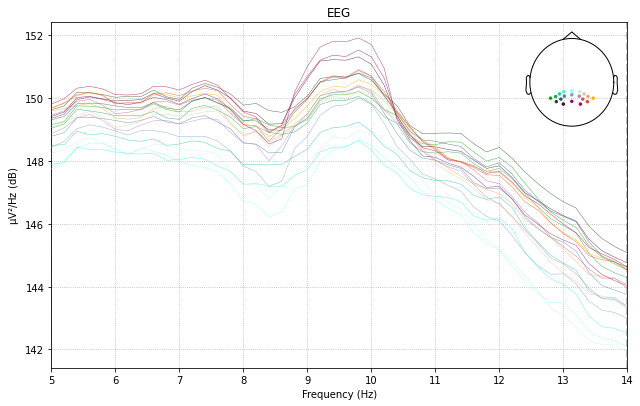

Evento:  3
Trial:  1
    Using multitaper spectrum estimation with 7 DPSS windows


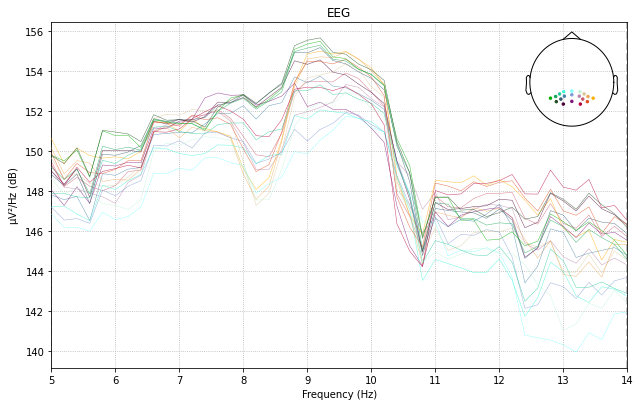

Trial:  3
    Using multitaper spectrum estimation with 7 DPSS windows


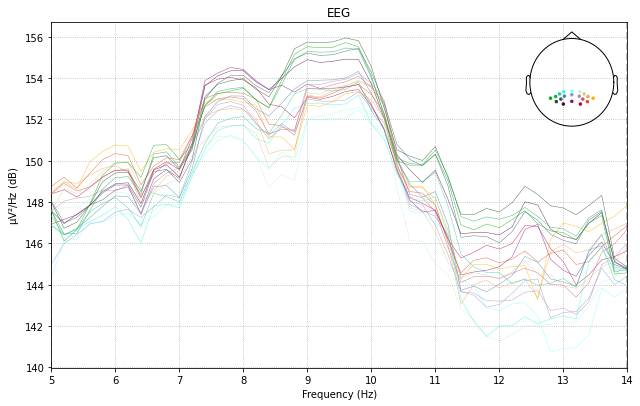

Trial:  9
    Using multitaper spectrum estimation with 7 DPSS windows


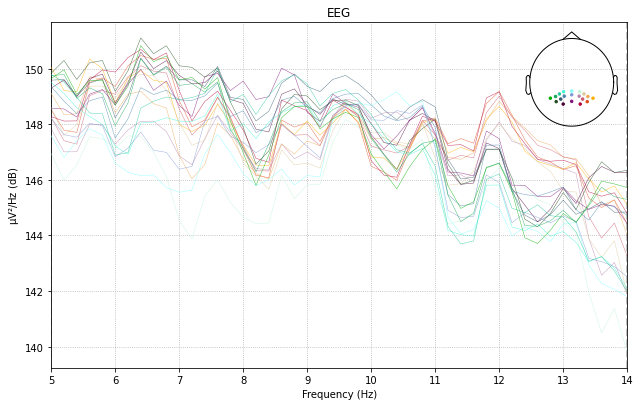

Trial:  11
    Using multitaper spectrum estimation with 7 DPSS windows


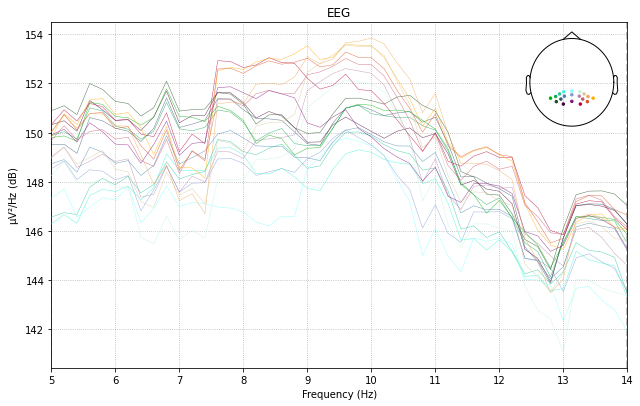

    Using multitaper spectrum estimation with 7 DPSS windows


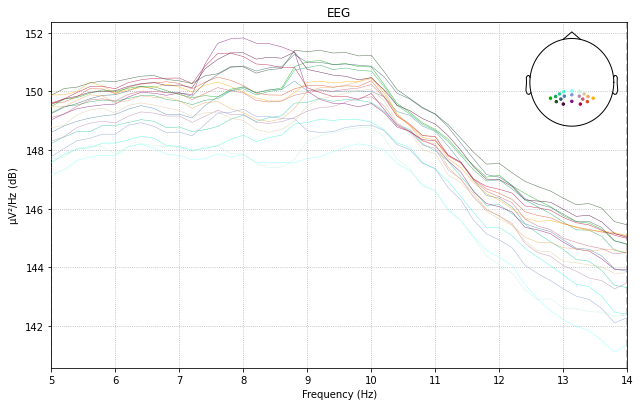

Evento:  4
Trial:  1
    Using multitaper spectrum estimation with 7 DPSS windows


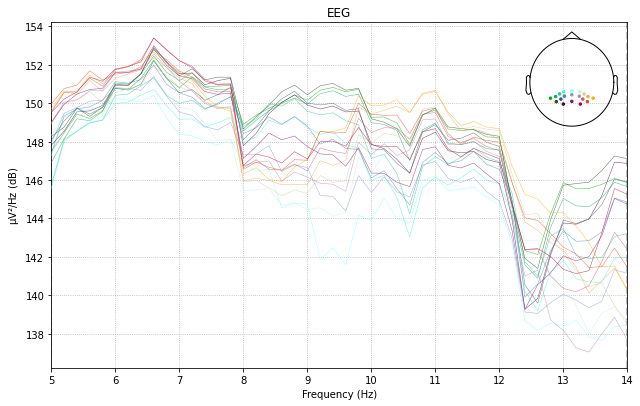

Trial:  3
    Using multitaper spectrum estimation with 7 DPSS windows


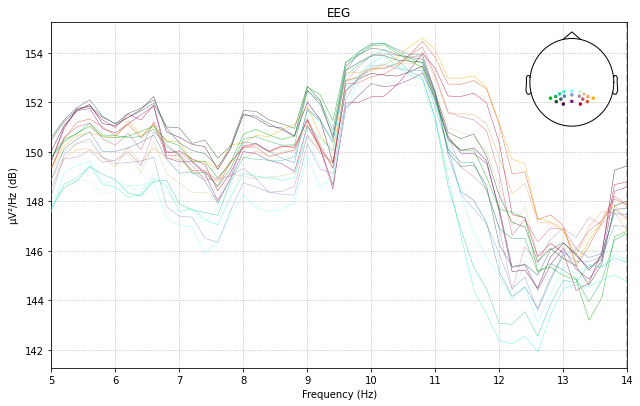

Trial:  9
    Using multitaper spectrum estimation with 7 DPSS windows


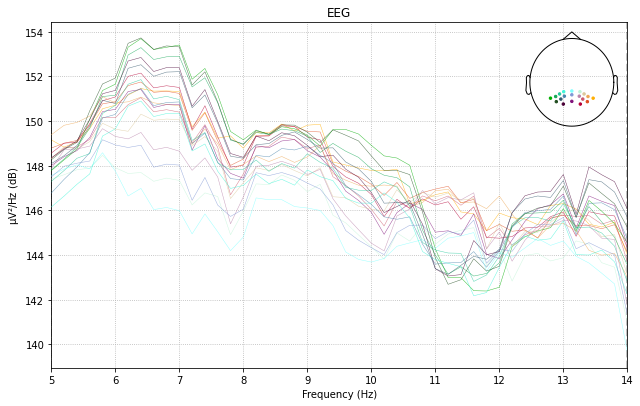

Trial:  11
    Using multitaper spectrum estimation with 7 DPSS windows


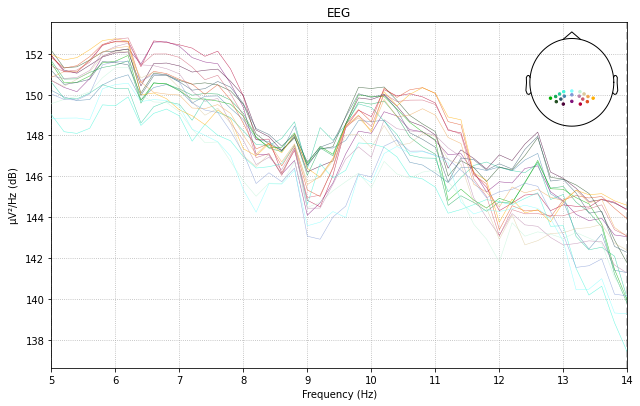

    Using multitaper spectrum estimation with 7 DPSS windows


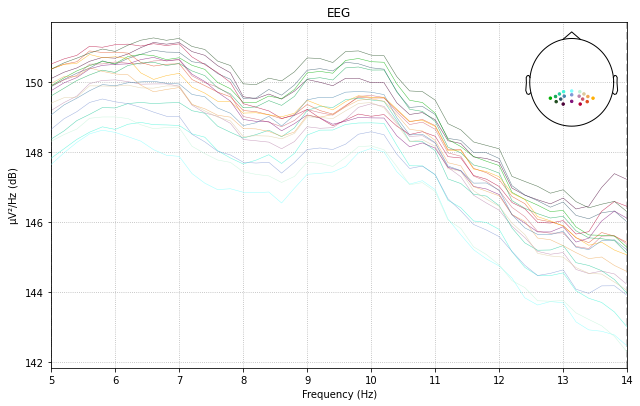

Evento:  5
Trial:  1
    Using multitaper spectrum estimation with 7 DPSS windows


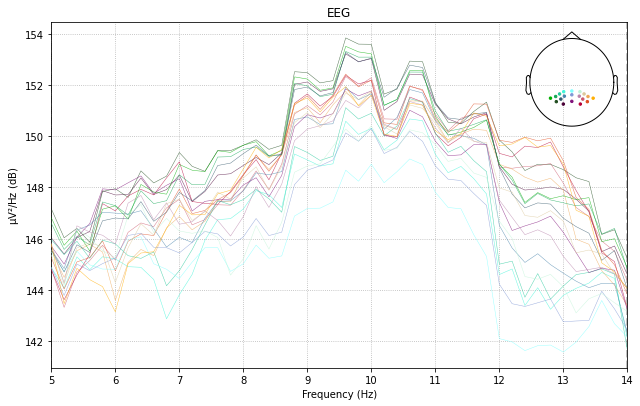

Trial:  3
    Using multitaper spectrum estimation with 7 DPSS windows


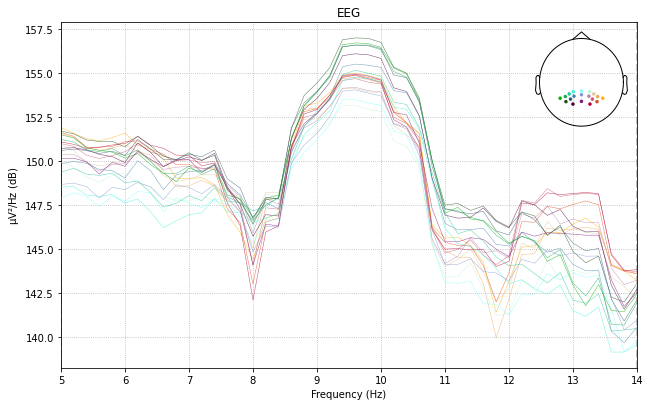

Trial:  9
    Using multitaper spectrum estimation with 7 DPSS windows


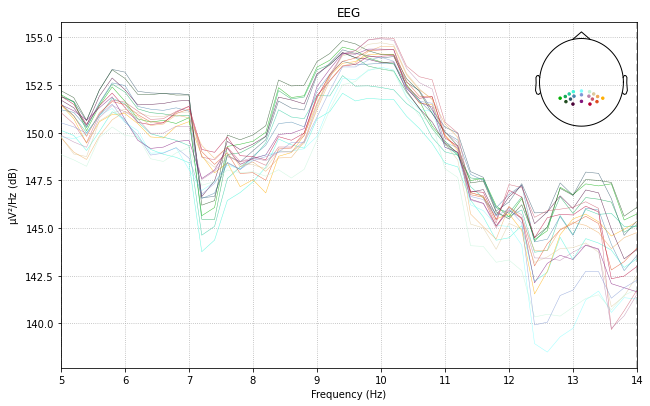

Trial:  11
    Using multitaper spectrum estimation with 7 DPSS windows


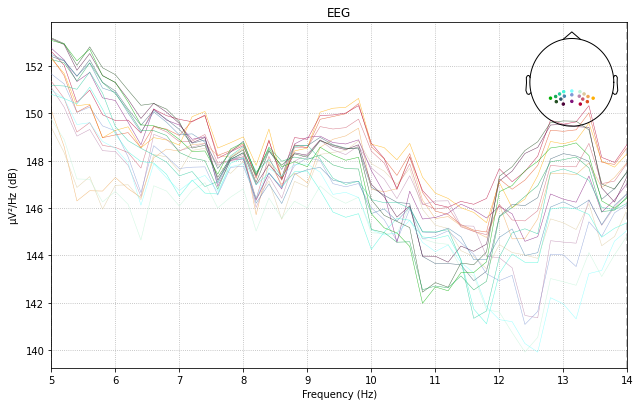

    Using multitaper spectrum estimation with 7 DPSS windows


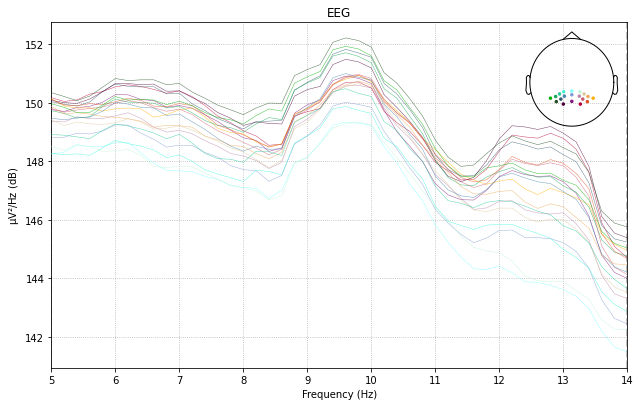

In [7]:
matplotlib.rcParams['figure.figsize'] = [8., 6.]

# Limitando as frequências
fmin = 5.0
fmax = 14.0
# filtro
epoch_ex.filter(l_freq=fmin, h_freq=fmax)
# filtrando os eventos
for e in ('1', '2', '3', '4', '5'):
    print("Evento: ", e)
    # selecionando os trials (1, 3, 9 e 11)
    for i in (1, 3, 9, 11):
        print("Trial: ", i)
        epoch_ex[e][-i].plot_psd(fmin=fmin, fmax=fmax)
    # mostrando todos os trials dos eventos
    matplotlib.rcParams['figure.figsize'] = [10., 6.]
    epoch_ex[e].plot_psd(fmin=fmin,fmax=fmax)
print()

Vamos explicar algumas coisas aqui rapidamente (próximas aulas tem mais...):
- Estamos plotando o `PSD` (*Power Spectrun Density*) do sinal. Isto é o sinal no domínio da frequência, com os valores das coordenadas apontando a força máxima no sinal de cada frequência da abcissa;
- Verificamos principalmente pelo gráfico do último plot um sinal mais "limpo" que os demais. Isto se dá pelo fato de que internamente, como não foi filtrado o *trial*, foi realizado a média bruta de todos os trials;
- Nestes gráficos já conseguimos ver algumas coisas interessantes, como por exemplo, que o sinal foi capturado em um país em que a energia da rede elétrica está em 50 Hz. percebemos isso pois o pico de energia está centrado para todos os eletrodos +/- nesse valor de frequência.

Porém, **ainda** não conseguimos enchergar o objeto de estudo: **as frequências evocadas no sinal**. Isto ocorre principalmente por que o sinal não está devidamente filtrado e a **faixa de frequência é muito larga** (0 - 120.5 Hz).

O método `plot_psd` possui diversos métodos e um deles e "estreitar" este valor mostrado. Vamos guardar estas informações para nossas tarefas...

### Salvando um objeto MNE no sistema de arquivos

Interessante salvar nosso novo objeto MNE Epoch em disco para não precisar executar toda vez os trechos de código anteriores.

In [8]:
epoch.save('ssvep-epo.fif', overwrite=True)

Overwriting existing file.


A título de curiosidade, o arquivo carregado posteriormente possui nomes de classe diferentes, porém possuem a mesma base e validade. Analisamos:

In [9]:
epoch_load = mne.read_epochs('ssvep-epo.fif')

Reading ssvep-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4995.85 ms
        0 CTF compensation matrices available
125 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


In [10]:
print(type(epoch), type(epoch_load))

<class 'mne.epochs.EpochsArray'> <class 'mne.epochs.EpochsFIF'>


In [11]:
# verificando se ambos os objetos possuem a mesma base de atributos e métodos
for obj in (epoch, epoch_load):
    print(isinstance(obj, mne.BaseEpochs))

True
True


### Resolução da tarefa

1. Realmente, com base no plots do grafico, percebe-se que os marcadores não estão mapeados para a frequência correta que foi dada: Rótulos: {'1': 6.66, '2': 7.5, '3': 8.57, '4': 10.0, '5': 12.0}. Na verdade, está na ordem inversa. 

**Rótulos Correto: {'5': 6.66, '4': 7.5, '3': 8.57, '2': 10.0, '1': 12.0}**

2. Como pode ser visto acima no código e nos gráficos, foi feito os filtros. Abaixo exemplo do filtro.

**Limitando as frequências**

fmin = 5.0
fmax = 14.0

**filtro**

epoch_ex.filter(l_freq=fmin, h_freq=fmax)

3.Realmente, é dificil saber quais contribuem. Para realizar a tarefa foi utilizado os eletrodos que estão/interferem na região da visão. **Filtrando apenas dados dos eletrodos (O1, Oz e O2), (P7-Pz-P8) e (PO7-POz-PO8)**

3.1 CAR: A técnica de filtragem espacial CAR reduz as componentes que estão em maior número nos eletrodos, subtraindo cada amostra do sinal pelo valor médio da diferença de potencial calculada para todos os eletrodos e a diferença aferida em cada eletrodo. No caso, nesse cenário o melhor é pegar a média do eletrododos.